# Data Analysis

#### Since my data do not contain null values and categorical variables, I will perform feature engineering and find correlations between the features


### Questions

In this analysis, I want to find the most helpful independent variables for predicting stocks prices (Open, Close, High, Low) along with the daily returns and the shifted returns by n day (for example I will buy a stock today and sell it at close in n days). In other words, I want to find features with highest correlation in order to predict stocks prices and returns, and determine a good timing to buy and sell stocks

### Feature Engineering

Please scroll down to Data Engineering section to see the code for feature engineering

I created a new variable called "daily_return", which calculates the percentage change in 2 successive closing price, assuming that I buy stocks and sell it the next day at closing.


I use Max Absolute Scaling for the dataset as financial data are sparse. I stored the scaled data into "scaled_df" dataframe

I also created an aggregated data framegrouped by ticker called "volatility" including 'ticker', 'daily_volatility', 'monthly_volatility', 'annual_volatility','returns', 'sharpe' which are popular indicator for stock prices. Please scroll down to the "Volatility dataframe" section to see how each variable is created. I plan to use this dataframe later for clustering the stocks

### Serial Correlation

I created a correlation matrix for all variables in the "scaled_df" dataframe except for 'daily_returns' in order to see the cross relation among variables and autocorrelation, which is demonstrated in the heatmap.

(I attached an image of the heatmap in the submission so that you can view it more clearly)

### Analysis


Based on the heatmap, all prices and shifted prices seem to positively correlated (including Open, Close, High, Low and their shifted variables). However, daily_returns and shifted_return variables do not have strong relation with other variables, meaning it would be difficult to predict the returns based on stocks prices and volumes.

Therefore, I think a good strategy would be diversifying one's portfolio with the assumption that a diversified portfolio would help us mitigate the risks. I plan to create a diversified portfolio by clustering the stocks based on the "volatility" dataframe created 

_______________________________________________________________________________________________________________________________

## Collect and preprocess data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 KB 1.8 MB/s eta 0:00:00


In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/114.3 KB 1.8 MB/s eta 0:00:00


In [ ]:
pip install talib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement talib (from versions: none)
ERROR: No matching distribution found for talib


In [ ]:
import os
import seaborn as sns
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
from yahooquery import Ticker
import yfinance as yf
#from talib import RSI, BBANDS, MACD, NATR, ATR
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,}'.format
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 100)

### Historical Pricing

#### Data from Wikipedia consists of constituents of S&P 500 

In [ ]:
# Compare downloads for all companies within the S&P500
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
tables.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:
sp500 = tables['Symbol'].tolist()
sp500 = [symbol.replace(".", "-") for symbol in sp500]


#### Collect 2-year of historical data from yfinance

In [ ]:
%%time
yf_data = yf.download(sp500, period='4y', interval='1d', group_by='ticker')

[*********************100%***********************]  503 of 503 completed
CPU times: user 18.3 s, sys: 1.2 s, total: 19.5 s
Wall time: 1min


#### Market Capitalization data from yfinance

In [ ]:
from pandas_datareader import data
market_cap ={}
for str in sp500:
    ticker = str
    market_cap[ticker]=int(data.get_quote_yahoo(str)['marketCap'])


In [ ]:
market_cap = pd.DataFrame(market_cap.items())
some_dict={0:"ticker",1:"market_cap"}
market_cap.rename(columns=some_dict, inplace=True)
market_cap

,ticker,market_cap
0,MMM,57411641344
1,AOS,10162616320
2,ABT,171553030144
3,ABBV,276822622208
4,ACN,162572484608
...,...,...
498,YUM,35993878528
499,ZBRA,14942832640
500,ZBH,26826223616
501,ZION,4759740928


In [ ]:
yf_data.columns.set_names(["ticker","Stats"],inplace=True)


In [ ]:
df = yf_data.stack(level=0)


In [ ]:
df_2019 = df[df.reset_index(level=1).index < '2020-01-01']
df_2020 = df[df.reset_index(level=1).index < '2021-01-01']
df_2021 = df[df.reset_index(level=1).index < '2022-01-01']
df_2022 = df[df.reset_index(level=1).index < '2023-01-01']
df_2023 = df[df.reset_index(level=1).index >= '2023-01-01']

In [ ]:
s_2019 = df_2019.groupby('ticker').count()['Close'].reset_index().rename(columns = {"Close":"days"}).ticker.values
s_2020 = df_2020.groupby('ticker').count()['Close'].reset_index().rename(columns = {"Close":"days"}).ticker.values
s_2021 = df_2021.groupby('ticker').count()['Close'].reset_index().rename(columns = {"Close":"days"}).ticker.values
s_2022 = df_2022.groupby('ticker').count()['Close'].reset_index().rename(columns = {"Close":"days"}).ticker.values
s_2023 = df_2023.groupby('ticker').count()['Close'].reset_index().rename(columns = {"Close":"days"}).ticker.values

In [ ]:
print("Stocks tickers in SP500 index that were not public:")
print("2019:",list(set(sp500).symmetric_difference(set(s_2019))))
print("2020:",list(set(sp500).symmetric_difference(set(s_2020))))
print("2021:",list(set(sp500).symmetric_difference(set(s_2021))))
print("2022:",list(set(sp500).symmetric_difference(set(s_2022))))
print("2023:",list(set(sp500).symmetric_difference(set(s_2022))))

exclude = list(set(sp500).symmetric_difference(set(s_2019)))

Stocks tickers in SP500 index that were not public:
2019: ['OGN', 'OTIS', 'CEG', 'GEHC', 'CARR']
2020: ['OGN', 'CEG', 'GEHC']
2021: ['CEG', 'GEHC']
2022: []
2023: []


In [ ]:
merged_df = df.merge(market_cap,on="ticker")
#merged_df = merged_df[~merged_df.ticker.isin(exclude)]
df_2019 = df_2019.merge(market_cap,on="ticker")
df_2020 = df_2020.merge(market_cap,on="ticker")
df_2021 = df_2021.merge(market_cap,on="ticker")
df_2022 = df_2022.merge(market_cap,on="ticker")
df_2023 = df_2023.merge(market_cap,on="ticker")



## Data Engineering

In [ ]:
merged_df['daily_returns_overall']=(merged_df.groupby('ticker').Close.pct_change())*100
def condition(x):
    if x>0:
        return "increase"
    elif x==0:
        return "unchanged"
    else:
        return 'decrease'
merged_df['trend'] = merged_df['daily_returns_overall'].shift(-1).apply(condition)


In [ ]:


df_2019['daily_returns_2019']=(df_2019.groupby('ticker').Close.pct_change())*100
df_2020['daily_returns_2020']=(df_2020.groupby('ticker').Close.pct_change())*100
df_2021['daily_returns_2021']=(df_2021.groupby('ticker').Close.pct_change())*100
df_2022['daily_returns_2022']=(df_2022.groupby('ticker').Close.pct_change())*100
df_2023['daily_returns_2023']=(df_2023.groupby('ticker').Close.pct_change())*100


In [ ]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
scaler = MaxAbsScaler()#StandardScaler()
scaled_df = pd.concat([merged_df.ticker,pd.DataFrame(scaler.fit_transform(merged_df.iloc[:,2:-1]),columns=merged_df.columns[2:-1]),merged_df['daily_returns_overall']],axis=1)
scaled_df.head(255)

,ticker,Close,High,Low,Open,Volume,market_cap,daily_returns_overall,daily_returns_overall
0,A,0.013254845230627393,0.013653268750849858,0.013421005298096228,0.013640903769314936,0.0015707562341234157,0.015991523783555908,NaN,NaN
1,A,0.013343781196977428,0.013349045625641015,0.013368321002642616,0.013231040189443925,0.001009756236311403,0.015991523783555908,0.010852317101671146,0.670969481744943
2,A,0.013533400645472224,0.013546289274422306,0.013618147411052852,0.013448518927851287,0.00156244188158174,0.015991523783555908,0.022983897438854883,1.4210323572882544
3,A,0.013256523630061448,0.013501156550597459,0.013407408932617626,0.01346692103385477,0.0015820243698048972,0.015991523783555908,-0.03309022147180338,-2.0458791006339405
4,A,0.013373985985572125,0.01333734478525975,0.01337681775860116,0.013281227983331352,0.0017674563113593748,0.015991523783555908,0.014331404807495765,0.8860720863825167
...,...,...,...,...,...,...,...,...,...
250,A,0.011034797749770007,0.011465201397185681,0.010905734735869012,0.011466121490555781,0.0037531643769377365,0.015991523783555908,-0.0730382034170214,-4.515755025878676
251,A,0.011152260105280684,0.011868046984433146,0.011039995927573461,0.0110395290714985,0.0035646692528679045,0.015991523783555908,0.01721686348864011,1.0644722103141824
252,A,0.010633745421234166,0.011293031342163088,0.010552237661460406,0.011175035604463106,0.003270603731393901,0.015991523783555908,-0.0752000064606023,-4.649413474502772
253,A,0.011242874471064772,0.01139666826789426,0.010978813579540527,0.010962575390178763,0.0031385586851070254,0.015991523783555908,0.0926494319682791,5.728264366892377


### Volatility datafame

Daily volatility: to get it, we calculate the standard deviation of the daily returns. The standard deviation helps us to see how much the data is spread around the mean or average.

Monthly volatility: we make the assumption that there are 21 trading days in the month so we multiply the daily volatility by the square root of 21.

Annual volatility: we assume there are 252 trading days in a calendar year and we multiply the daily volatility by the square root of 252.

In [ ]:
#volatility=(scaled_df.groupby('ticker')['daily_returns_overall'].std())
scaler = MaxAbsScaler()


In [ ]:

def get_volatility(df,time,is_merged_df=False):
    #print(df)
    #n_days = df.groupby('ticker').count()['Close'].reset_index().rename(columns = {"Close":"days"})
    if is_merged_df:
        scaled_df = pd.concat([df.ticker,pd.DataFrame(scaler.fit_transform(df.iloc[:,1:-2]),columns=df.columns[1:-2]),df[f'daily_returns_{time}'],df['trend']],axis=1)

    if not (is_merged_df):
        scaled_df = pd.concat([df.ticker,pd.DataFrame(scaler.fit_transform(df.iloc[:,1:-1]),columns=df.columns[1:-1]),df[f'daily_returns_{time}']],axis=1)
    
    volatility=(scaled_df.groupby('ticker')[f'daily_returns_{time}'].std())

    volatility = volatility.reset_index().rename(columns={f'daily_returns_{time}': f'daily_volatility_{time}'})
    
    volatility[f'annual_volatility_{time}']= math.sqrt(252) * volatility[f'daily_volatility_{time}']
    #volatility[f'n_days_{time}']= n_days.days
    #print(volatility)
    ret_df= pd.DataFrame(columns=['ticker',f'returns_{time}',f'market_{time}'])
    ret = {}
    #print(len(volatility['ticker']))
    df_list = [v for k, v in df.groupby('ticker')]
    for v in df_list:
        #print(v)
        v[f'returns_{time}'] = v.Close.pct_change(len(v)-1)
        v[f'market_{time}'] = v.market_cap
        v.dropna(inplace=True)
        v = v[['ticker',f'returns_{time}',f'market_{time}']]
        ret_df = ret_df.append(v.iloc[0,:], ignore_index = True)
        
    #df_list
    
    
    volatility = volatility.merge(ret_df,on='ticker')
    
    
    return scaled_df,volatility

    #ret.append(merged_df.groupby('ticker').Close.pct_change(days).dropna())

In [ ]:
scaled_df,overall_vol = get_volatility(merged_df.reset_index().iloc[:,1:],'overall',True)
scaled_df

,ticker,Adj Close,Close,High,Low,Open,Volume,market_cap,daily_returns_overall,trend
0,A,0.012882004991434453,0.013254845230627393,0.013653268750849858,0.013421005298096228,0.013640903769314936,0.0015707562341234157,0.015991523783555908,NaN,increase
1,A,0.01296843808143546,0.013343781196977428,0.013349045625641015,0.013368321002642616,0.013231040189443925,0.001009756236311403,0.015991523783555908,0.670969481744943,increase
2,A,0.013152725315099714,0.013533400645472224,0.013546289274422306,0.013618147411052852,0.013448518927851287,0.00156244188158174,0.015991523783555908,1.4210323572882544,decrease
3,A,0.012883636021853205,0.013256523630061448,0.013501156550597459,0.013407408932617626,0.01346692103385477,0.0015820243698048972,0.015991523783555908,-2.0458791006339405,increase
4,A,0.012997795348729359,0.013373985985572125,0.01333734478525975,0.01337681775860116,0.013281227983331352,0.0017674563113593748,0.015991523783555908,0.8860720863825167,increase
...,...,...,...,...,...,...,...,...,...,...
504278,GEHC,0.01285715034108149,0.01285715034108149,0.01294620003839355,0.012873763905479872,0.01270741999257483,0.0017773022551587276,0.013759165355650653,-0.18238585950006714,decrease
504279,GEHC,0.012726262070342035,0.012726262070342035,0.01296124470476715,0.012819379740186241,0.012857982097908496,0.006346804772438359,0.013759165355650653,-1.0180192909562402,decrease
504280,GEHC,0.012618867550948371,0.012618867550948371,0.012672064970635954,0.012663025427044646,0.012628793044437883,0.0018752146962745136,0.013759165355650653,-0.8438810925003759,increase
504281,GEHC,0.012840368907228259,0.012840368907228259,0.012817490794199636,0.012831276235824822,0.012655560208198809,0.0015329040501836815,0.013759165355650653,1.7553188143514697,increase


In [ ]:
scaled_2019,vol_2019 = get_volatility(df_2019.reset_index().iloc[:,1:],'2019')

In [ ]:
scaled_2020, vol_2020 = get_volatility(df_2020.reset_index().iloc[:,1:],'2020')

In [ ]:
scaled_2021, vol_2021 = get_volatility(df_2021.reset_index().iloc[:,1:],'2021')

In [ ]:
scaled_2022,vol_2022 = get_volatility(df_2022.reset_index().iloc[:,1:],'2022')

In [ ]:
scaled_2023,vol_2023 = get_volatility(df_2023.reset_index().iloc[:,1:],'2023')

## Correlation

### Clustering

In [ ]:
pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator

def find_k_means(X,time,n_cluster = 20):
    Sum_of_squared_distances = []
    K = range(1,50)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(X.iloc[:,1:])
        Sum_of_squared_distances.append(km.inertia_)

    kneedle = KneeLocator(K,Sum_of_squared_distances , curve="convex", direction="decreasing")
    kneedle.plot_knee()

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    #kneedle.plot_knee_normalized()
    #plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


    plt.show()
    k_best = kneedle.knee


    print("Optimum Number of Clusters:", k_best)
    
    kmeans = KMeans(n_clusters = k_best).fit(X.iloc[:,1:])
    lbl = kmeans.labels_
    X= pd.concat([X,pd.DataFrame({f'labels_{time}':lbl})],axis=1)
    
    print(X[f'labels_{time}'].value_counts())

    return k_best,X


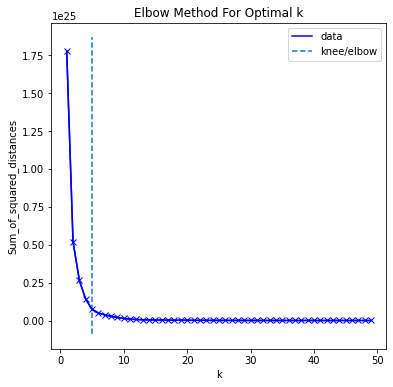

Optimum Number of Clusters: 5
0    420
4     65
3     13
2      3
1      2
Name: labels_overall, dtype: int64


In [ ]:
overall_vol_X = ['ticker','annual_volatility_overall','returns_overall','market_overall']
k_all,overall_vol_lbl = find_k_means(overall_vol[overall_vol_X],'overall')


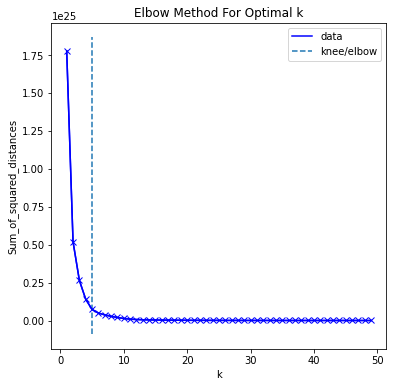

Optimum Number of Clusters: 5
0    415
4     65
3     13
2      3
1      2
Name: labels_2019, dtype: int64


In [ ]:
X_vol_2019 = ['ticker','annual_volatility_2019','returns_2019','market_2019']
k_19,vol_lbl_19 = find_k_means(vol_2019[X_vol_2019],'2019')


In [ ]:
vol_2019

,ticker,daily_volatility_2019,annual_volatility_2019,returns_2019,market_2019
0,A,1.583202488064052,25.132560350857126,0.08001012616463199,40412114944
1,AAL,2.152568120345618,34.17095955936156,-0.061825299591626526,9364320256
2,AAP,1.5817941341158481,25.110203425027706,-0.028391123390879902,7032243712
3,AAPL,1.4851675794997432,23.576304423672422,0.5370321340268753,2527095947264
4,ABBV,1.7103415846802654,27.15083094021661,0.11008022246915927,276822622208
...,...,...,...,...,...
493,YUM,1.0077671698175459,15.997807864755744,0.017783187981433413,35993878528
494,ZBH,1.3523843971566396,21.46843675104285,0.18155987286564024,26826223616
495,ZBRA,2.4993429300514243,39.67583900390143,0.23258056200848776,14942832640
496,ZION,1.6247714384326566,25.792446980481014,0.18973416349911587,4759740928


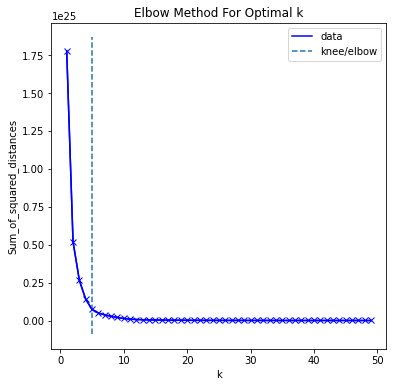

Optimum Number of Clusters: 5
2    417
0     65
4     13
3      3
1      2
Name: labels_2020, dtype: int64


In [ ]:
X_vol_2020 = ['ticker','annual_volatility_2020','returns_2020','market_2020']
k_20,vol_lbl_20 = find_k_means(vol_2020[X_vol_2020],'2020')


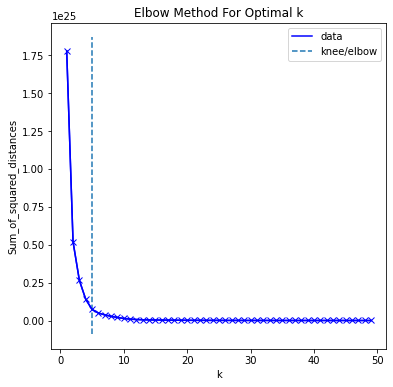

Optimum Number of Clusters: 5
0    418
4     65
2     13
3      3
1      2
Name: labels_2021, dtype: int64


In [ ]:
X_vol_2021 = ['ticker','annual_volatility_2021','returns_2021','market_2021']
k_21,vol_lbl_21 = find_k_means(vol_2021[X_vol_2021],'2021')


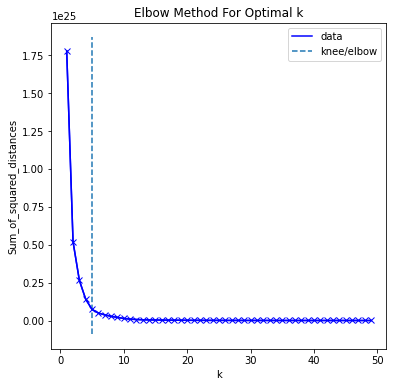

Optimum Number of Clusters: 5
0    420
3     65
2     13
1      3
4      2
Name: labels_2022, dtype: int64


In [ ]:
X_vol_2022 = ['ticker','annual_volatility_2022','returns_2022','market_2022']
k_22,vol_lbl_22 = find_k_means(vol_2022[X_vol_2022],'2022')


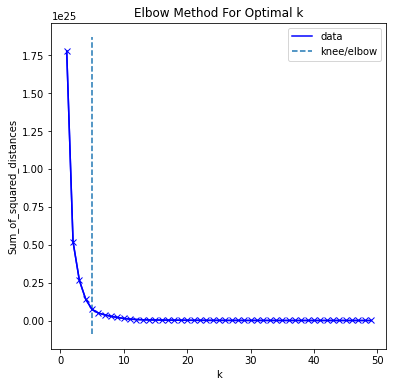

Optimum Number of Clusters: 5
0    420
4     65
2     13
3      3
1      2
Name: labels_2023, dtype: int64


In [ ]:
X_vol_2023 = ['ticker','annual_volatility_2023','returns_2023','market_2023']
k_23,vol_lbl_23 = find_k_means(vol_2023[X_vol_2023],'2023')


In [ ]:
lbl_19 = vol_lbl_19['labels_2019']
lbl_20 = vol_lbl_20['labels_2020']
lbl_21 = vol_lbl_21['labels_2021']
lbl_22 = vol_lbl_22['labels_2022'] 
lbl_23 = vol_lbl_23['labels_2023']

label_df = pd.concat([vol_2023.ticker, lbl_19, lbl_20, lbl_21, lbl_22, lbl_23 ],axis = 1)
label_df2 = label_df.dropna()


In [ ]:
#label_df.dropna()

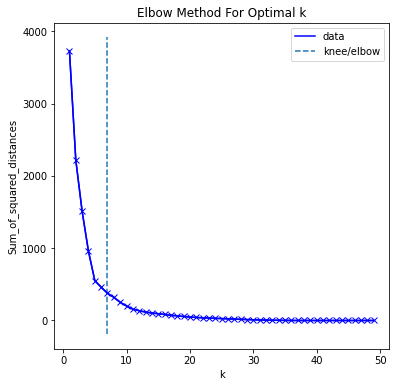

Optimum Number of Clusters: 7
1    321
2     56
0     52
5     36
4     17
3      9
6      7
Name: labels_all, dtype: int64


In [ ]:
k_all,lbl_all = find_k_means(label_df2,'all',70)


In [ ]:
lbl_all

,ticker,labels_2019,labels_2020,labels_2021,labels_2022,labels_2023,labels_all
0,A,0.0,2.0,0.0,0,0,1
1,AAL,0.0,2.0,0.0,0,0,1
2,AAP,0.0,2.0,0.0,0,0,1
3,AAPL,1.0,1.0,1.0,4,1,2
4,ABBV,4.0,0.0,4.0,3,4,4
...,...,...,...,...,...,...,...
493,WYNN,0.0,2.0,2.0,0,0,1
494,XEL,0.0,2.0,0.0,0,0,1
495,XOM,0.0,2.0,0.0,2,2,2
496,XRAY,0.0,2.0,0.0,0,0,1


In [ ]:
bucket = [v for k, v in lbl_all.groupby('labels_all')]
bucket

[    ticker  labels_2019  labels_2020  labels_2021  labels_2022  labels_2023  \
 70   BRK-B          3.0          4.0          2.0            2            2   
 78    CARR          4.0          2.0          0.0            0            0   
 98     CLX          4.0          2.0          0.0            0            0   
 107    COF          4.0          2.0          0.0            0            0   
 113    CPT          4.0          2.0          0.0            0            0   
 122   CTSH          4.0          2.0          0.0            0            0   
 128    DAL          4.0          2.0          0.0            0            0   
 133    DGX          4.0          2.0          0.0            0            0   
 155    EIX          4.0          2.0          0.0            0            0   
 197    FTV          4.0          2.0          0.0            0            0   
 205    GLW          2.0          2.0          0.0            0            0   
 210    GPC          4.0          2.0   

### Select stocks from each bucket

In [ ]:
selected = []
for b in bucket:
    b_df = overall_vol.merge(b,on='ticker')
    s = b_df.sort_values(by=["returns_overall","market_overall"],ascending=False).iloc[0,0]
    selected.append(s)
    

In [ ]:
#Create dependent column
merged_df['pred_price'] = merged_df.groupby('ticker').Close.shift(-1)
scaled_df['pred_price'] = scaled_df.groupby('ticker').Close.shift(-1)
merged_df
scaled_df

,ticker,Adj Close,Close,High,Low,Open,Volume,market_cap,daily_returns_overall,trend,pred_price
0,A,76.76811981201172,78.98999786376953,81.68000030517578,78.97000122070312,81.54000091552734,"1,435,800.0",40412114944,NaN,increase,79.5199966430664
1,A,77.283203125,79.5199966430664,79.86000061035156,78.66000366210938,79.08999633789062,"923,000.0",40412114944,0.670969481744943,increase,80.6500015258789
2,A,78.38143157958984,80.6500015258789,81.04000091552734,80.12999725341797,80.38999938964844,"1,428,200.0",40412114944,1.4210323572882544,decrease,79.0
3,A,76.77783966064453,79.0,80.7699966430664,78.88999938964844,80.5,"1,446,100.0",40412114944,-2.0458791006339405,increase,79.69999694824219
4,A,77.4581527709961,79.69999694824219,79.79000091552734,78.70999908447266,79.38999938964844,"1,615,600.0",40412114944,0.8860720863825167,increase,80.37999725341797
...,...,...,...,...,...,...,...,...,...,...,...
504278,GEHC,76.62000274658203,76.62000274658203,77.44999694824219,75.75,75.95999908447266,"1,624,600.0",34770731008,-0.18238585950006714,decrease,75.83999633789062
504279,GEHC,75.83999633789062,75.83999633789062,77.54000091552734,75.43000030517578,76.86000061035156,"5,801,500.0",34770731008,-1.0180192909562402,decrease,75.19999694824219
504280,GEHC,75.19999694824219,75.19999694824219,75.80999755859375,74.51000213623047,75.48999786376953,"1,714,100.0",34770731008,-0.8438810925003759,increase,76.5199966430664
504281,GEHC,76.5199966430664,76.5199966430664,76.68000030517578,75.5,75.6500015258789,"1,401,200.0",34770731008,1.7553188143514697,increase,76.6500015258789


,ticker,Adj Close,Close,High,Low,Open,Volume,market_cap,daily_returns_overall,trend,pred_price
0,A,0.012882004991434453,0.013254845230627393,0.013653268750849858,0.013421005298096228,0.013640903769314936,0.0015707562341234157,0.015991523783555908,NaN,increase,0.013343781196977428
1,A,0.01296843808143546,0.013343781196977428,0.013349045625641015,0.013368321002642616,0.013231040189443925,0.001009756236311403,0.015991523783555908,0.670969481744943,increase,0.013533400645472224
2,A,0.013152725315099714,0.013533400645472224,0.013546289274422306,0.013618147411052852,0.013448518927851287,0.00156244188158174,0.015991523783555908,1.4210323572882544,decrease,0.013256523630061448
3,A,0.012883636021853205,0.013256523630061448,0.013501156550597459,0.013407408932617626,0.01346692103385477,0.0015820243698048972,0.015991523783555908,-2.0458791006339405,increase,0.013373985985572125
4,A,0.012997795348729359,0.013373985985572125,0.01333734478525975,0.01337681775860116,0.013281227983331352,0.0017674563113593748,0.015991523783555908,0.8860720863825167,increase,0.01348809282245835
...,...,...,...,...,...,...,...,...,...,...,...
504278,GEHC,0.01285715034108149,0.01285715034108149,0.01294620003839355,0.012873763905479872,0.01270741999257483,0.0017773022551587276,0.013759165355650653,-0.18238585950006714,decrease,0.012726262070342035
504279,GEHC,0.012726262070342035,0.012726262070342035,0.01296124470476715,0.012819379740186241,0.012857982097908496,0.006346804772438359,0.013759165355650653,-1.0180192909562402,decrease,0.012618867550948371
504280,GEHC,0.012618867550948371,0.012618867550948371,0.012672064970635954,0.012663025427044646,0.012628793044437883,0.0018752146962745136,0.013759165355650653,-0.8438810925003759,increase,0.012840368907228259
504281,GEHC,0.012840368907228259,0.012840368907228259,0.012817490794199636,0.012831276235824822,0.012655560208198809,0.0015329040501836815,0.013759165355650653,1.7553188143514697,increase,0.012862184259139998


In [ ]:
merged_df

,ticker,Adj Close,Close,High,Low,Open,Volume,market_cap,daily_returns_overall,trend,pred_price
0,A,76.76811981201172,78.98999786376953,81.68000030517578,78.97000122070312,81.54000091552734,"1,435,800.0",40412114944,NaN,increase,79.5199966430664
1,A,77.283203125,79.5199966430664,79.86000061035156,78.66000366210938,79.08999633789062,"923,000.0",40412114944,0.670969481744943,increase,80.6500015258789
2,A,78.38143157958984,80.6500015258789,81.04000091552734,80.12999725341797,80.38999938964844,"1,428,200.0",40412114944,1.4210323572882544,decrease,79.0
3,A,76.77783966064453,79.0,80.7699966430664,78.88999938964844,80.5,"1,446,100.0",40412114944,-2.0458791006339405,increase,79.69999694824219
4,A,77.4581527709961,79.69999694824219,79.79000091552734,78.70999908447266,79.38999938964844,"1,615,600.0",40412114944,0.8860720863825167,increase,80.37999725341797
...,...,...,...,...,...,...,...,...,...,...,...
504278,GEHC,76.62000274658203,76.62000274658203,77.44999694824219,75.75,75.95999908447266,"1,624,600.0",34770731008,-0.18238585950006714,decrease,75.83999633789062
504279,GEHC,75.83999633789062,75.83999633789062,77.54000091552734,75.43000030517578,76.86000061035156,"5,801,500.0",34770731008,-1.0180192909562402,decrease,75.19999694824219
504280,GEHC,75.19999694824219,75.19999694824219,75.80999755859375,74.51000213623047,75.48999786376953,"1,714,100.0",34770731008,-0.8438810925003759,increase,76.5199966430664
504281,GEHC,76.5199966430664,76.5199966430664,76.68000030517578,75.5,75.6500015258789,"1,401,200.0",34770731008,1.7553188143514697,increase,76.6500015258789


In [ ]:
df_list = [v for k, v in merged_df.groupby('ticker')]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf



In [ ]:
df_list2 = [v for k, v in scaled_df.groupby('ticker')]


In [ ]:

#input_shape = X1_train.shape
batch_size=128

lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=( 7,1)))
lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(1, 'linear'))
#lstm_model.add(Dense(1, activation='linear'))

lstm_model.summary()
cp1 = ModelCheckpoint('model/', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 67,601
Trainable params: 67,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:

from tensorflow.keras import initializers


lstm_model2 = Sequential()
lstm_model2.add(LSTM(4 * 4, return_sequences=True,input_shape=( 7,1), activation='tanh',
                   recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform',
                   recurrent_initializer='orthogonal', bias_initializer='zeros',
                   ))

lstm_model2.add(LSTM(4, return_sequences=False, activation='tanh',
                            recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal', bias_initializer='zeros',
                            ))
lstm_model2.add(Dense(1, kernel_initializer=initializers.glorot_uniform()))
lstm_model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

lstm_model2.summary()
cp2 = ModelCheckpoint('model/', save_best_only=True)
lstm_model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 16)             1152      
                                                                 
 lstm_2 (LSTM)               (None, 4)                 336       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


In [ ]:
scaled_df2 = merged_df
scaled_df2['next_day_return']= scaled_df2.daily_returns_overall.shift(-1)
df_list3 = [v for k, v in scaled_df2.groupby('ticker')]


In [ ]:
scaled_df3 = scaled_df

scaled_df3['next_day_return']= scaled_df3.daily_returns_overall.shift(-1)
df_list4 = [v for k, v in scaled_df2.groupby('ticker')]

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report

output_list1 =[]
acc1 = {}
profit1={}
ratio = 0.8
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    """
    train_size = math.ceil(len(X)*0.8)
    X_train_orig, X_test_orig= X[:train_size],X[train_size:]
    y_train, y_test= y[:train_size],y[train_size:]"""
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    


    """
    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)
    svr_rbf.fit(X_train,y_train)
    svm_scores = svr_rbf.score(X_test,y_test)
    svm_scores
    """
    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model2.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    predictions = lstm_model2.predict(X1_test)
    
    pred1 = predictions.reshape(y1_test.shape)
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    pred_cat = (pred1-X_test.Close).apply(condition)
    X_test.Close-pred1
    #pred2

    pred = (y_test-X_test.Close).apply(condition)

   

    #pred
    acc = sum(pred==pred_cat)/len(pred)
    acc1[s]=acc

    confusion_matrix(pred, pred_cat)

    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    output_list1.append(stock_test_df)
    
    profit1[s] = sum(stock_test_df['profit'])    

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 2ms/step


90516    -0.7360763549804688
90517    0.28437042236328125
90518   -0.16233444213867188
90519   -0.10193252563476562
90520     0.5206832885742188
                ...         
90713     1.2576541900634766
90714     1.3707733154296875
90715     0.4202117919921875
90716    0.01905059814453125
90717    0.22197723388671875
Name: Close, Length: 202, dtype: float64

array([[58, 51,  0],
       [45, 47,  0],
       [ 1,  0,  0]])

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 2ms/step


172164      -0.20294189453125
172165   -0.23419570922851562
172166    -0.4781532287597656
172167    -0.6788063049316406
172168    -0.8237648010253906
                 ...         
172361    -0.5314445495605469
172362    -0.4091453552246094
172363   -0.44820404052734375
172364    -0.9162979125976562
172365    -1.1309585571289062
Name: Close, Length: 202, dtype: float64

array([[  0, 102,   0],
       [  2,  96,   0],
       [  0,   2,   0]])

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 3ms/step


443316    -0.5754623413085938
443317     0.7224044799804688
443318     1.0198898315429688
443319    -0.7814788818359375
443320    0.35752105712890625
                 ...         
443513   -0.07663345336914062
443514    -0.5759544372558594
443515      -0.53521728515625
443516    -0.7045631408691406
443517    -0.8257217407226562
Name: Close, Length: 202, dtype: float64

array([[  9, 101],
       [  6,  86]])

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 2ms/step


138900   2.4014434814453125
138901     4.05059814453125
138902     2.96258544921875
138903    2.225189208984375
138904   5.1128997802734375
                ...        
139097   7.0682525634765625
139098   5.4015045166015625
139099   4.8128509521484375
139100     4.72943115234375
139101   3.7218170166015625
Name: Close, Length: 202, dtype: float64

array([[ 97,   1,   0],
       [103,   0,   0],
       [  1,   0,   0]])

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 3ms/step


28021    -2.1784133911132812
28022     -0.715301513671875
28023    -0.7591323852539062
28024     -3.675384521484375
28025     -0.636199951171875
                ...         
28218   -0.22841644287109375
28219       -0.0775146484375
28220     -4.513481140136719
28221    -3.5108871459960938
28222    -2.8615188598632812
Name: Close, Length: 202, dtype: float64

array([[18, 82],
       [18, 84]])

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 2ms/step


320340   -7.6226959228515625
320341    -5.036651611328125
320342     -7.23565673828125
320343    -8.738357543945312
320344        -4.83349609375
                 ...        
320537     1.592132568359375
320538    11.472381591796875
320539       7.1119384765625
320540    10.983062744140625
320541    14.532989501953125
Name: Close, Length: 202, dtype: float64

array([[37, 63,  0],
       [29, 72,  0],
       [ 0,  1,  0]])

'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

"\n    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)\n    svr_rbf.fit(X_train,y_train)\n    svm_scores = svr_rbf.score(X_test,y_test)\n    svm_scores\n    "

7/7 [==============================] - 0s 2ms/step


137892    10.285003662109375
137893     8.970413208007812
137894     9.314559936523438
137895    10.556488037109375
137896    11.530181884765625
                 ...        
138089      1.21270751953125
138090    0.9153900146484375
138091     1.015655517578125
138092    2.8632965087890625
138093   -1.5074310302734375
Name: Close, Length: 202, dtype: float64

array([[78, 29],
       [67, 28]])

In [ ]:
acc1

{'CARR': 0.5198019801980198,
 'ENPH': 0.4752475247524752,
 'TSLA': 0.47029702970297027,
 'DHR': 0.4801980198019802,
 'AMD': 0.504950495049505,
 'MRNA': 0.5396039603960396,
 'DHI': 0.5247524752475248}

In [ ]:
profit1

{'CARR': 741.1722338548282,
 'ENPH': -1983.5403224299273,
 'TSLA': -572.83783532973,
 'DHR': -17.06375900435787,
 'AMD': 927.8525237780125,
 'MRNA': 740.8416232664703,
 'DHI': -49.20119658671645}

In [ ]:
acc_df = pd.DataFrame([acc1],index=['LSTM2_trend'])
profit_df = pd.DataFrame([profit1],index=['LSTM2_trend'])

In [ ]:
model = tf.keras.Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(7, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile and train model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

acc2 = {}
profit2={}
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    
    """
    svr_rbf = SVR(kernel='rbf',C=1e3,gamma=0.1)
    svr_rbf.fit(X_train,y_train)
    svm_scores = svr_rbf.score(X_test,y_test)
    svm_scores
    """
    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model2.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    predictions = lstm_model2.predict(X1_test)
    
    pred1 = predictions.reshape(y1_test.shape)
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    pred2 = (pred1-X_test.Close).apply(condition)
    X_test.Close-pred1
    #pred2

    pred = (y_test-X_test.Close).apply(condition)

    #pred
    acc = sum(pred==pred2)/len(pred)
    acc2[s]=acc
    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']
    print(stock_test_df)
    output_list1.append(stock_test_df)
    
    profit2[s] = sum(stock_test_df['profit'])    

In [ ]:
acc2

{'CARR': 0.5247524752475248,
 'ENPH': 0.504950495049505,
 'TSLA': 0.43564356435643564,
 'DHR': 0.4306930693069307,
 'AMD': 0.504950495049505,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
profit2

{'CARR': -3687.9318670199514,
 'ENPH': -765.7824367634297,
 'TSLA': -1368.1476848734585,
 'DHR': -535.0884936735945,
 'AMD': 70.99224068117414,
 'MRNA': -141.7624687837607,
 'DHI': -49.20119658671645}

In [ ]:
acc_df = acc_df.append(pd.DataFrame([acc2],index=['LSTM2_val']))
profit_df = profit_df.append(pd.DataFrame([profit2],index=['LSTM2_val']))

In [ ]:
acc_df

,CARR,ENPH,TSLA,DHR,AMD,MRNA,DHI
LSTM2_trend,0.5198019801980198,0.4752475247524752,0.47029702970297027,0.4801980198019802,0.504950495049505,0.5396039603960396,0.5247524752475248
LSTM2_val,0.5247524752475248,0.504950495049505,0.43564356435643564,0.4306930693069307,0.504950495049505,0.49504950495049505,0.5297029702970297


In [ ]:
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)



In [ ]:
""""""
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

acc3 = {}
profit3={}
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle =False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    

    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)
    

    
    
    pred2 = (svm_predictions-X_test.Close).apply(condition)    


    
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']


    #X_test.Close-combined_pred
    #pred2

    pred = (y_test-X_test.Close).apply(condition)

    #pred
    acc = sum(pred==pred2)/len(pred)
    acc3[s]=acc

    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    output_list1.append(stock_test_df)
    
    profit3[s] = sum(stock_test_df['profit'])    

''

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

In [ ]:
acc3

{'CARR': 0.48514851485148514,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5445544554455446,
 'DHR': 0.4306930693069307,
 'AMD': 0.5,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
profit3

{'CARR': -3687.9318670199514,
 'ENPH': -765.7824367634297,
 'TSLA': -1368.1476848734585,
 'DHR': -535.0884936735945,
 'AMD': 70.99224068117414,
 'MRNA': -141.7624687837607,
 'DHI': -49.20119658671645}

In [ ]:
acc_df = acc_df.append(pd.DataFrame([acc3],index=['SVR_val']))
profit_df = profit_df.append(pd.DataFrame([profit3],index=['SVR_val']))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

acc4 = {}
#Tesla
profit4={}
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['trend']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y_encoded,test_size=0.2,shuffle=False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    


    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model2.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    lstm_predictions = lstm_model2.predict(X1_test)
    
    
    
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)
    
    lstm_predictions = lstm_predictions.reshape(y1_test.shape)
    combined_pred = (lstm_predictions + svm_predictions) / 2
    
    
    pred2 = (combined_pred-X_test.Close).apply(condition)
    #X_test.Close-combined_pred
    #pred2

    pred = (y1_test-X_test.Close).apply(condition)

    #pred
    acc = sum(pred==pred2)/len(pred)
    acc4[s]=acc

    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    profit4[s] = sum(stock_test_df['profit'])    

7/7 [==============================] - 0s 2ms/step


SVR(C=100, gamma=0.1)

7/7 [==============================] - 0s 2ms/step


SVR(C=100, gamma=0.1)

7/7 [==============================] - 0s 2ms/step


SVR(C=100, gamma=0.1)

7/7 [==============================] - 0s 3ms/step


SVR(C=100, gamma=0.1)

7/7 [==============================] - 0s 2ms/step


SVR(C=100, gamma=0.1)

7/7 [==============================] - 0s 3ms/step


SVR(C=100, gamma=0.1)

7/7 [==============================] - 0s 3ms/step


SVR(C=100, gamma=0.1)

In [ ]:
pred

137892    decrease
137893    decrease
137894    decrease
137895    decrease
137896    decrease
            ...   
138089    decrease
138090    decrease
138091    decrease
138092    decrease
138093    decrease
Name: Close, Length: 202, dtype: object

In [ ]:
pred2

137892    decrease
137893    decrease
137894    decrease
137895    decrease
137896    decrease
            ...   
138089    decrease
138090    decrease
138091    decrease
138092    decrease
138093    decrease
Name: Close, Length: 202, dtype: object

In [ ]:
acc4

{'CARR': 1.0,
 'ENPH': 1.0,
 'TSLA': 1.0,
 'DHR': 1.0,
 'AMD': 1.0,
 'MRNA': 1.0,
 'DHI': 1.0}

In [ ]:
profit4

{'CARR': -3687.9318670199514,
 'ENPH': -765.7824367634297,
 'TSLA': -1368.1476848734585,
 'DHR': -535.0884936735945,
 'AMD': 70.99224068117414,
 'MRNA': -141.7624687837607,
 'DHI': -49.20119658671645}

In [ ]:
acc1

{'CARR': 0.5198019801980198,
 'ENPH': 0.4752475247524752,
 'TSLA': 0.47029702970297027,
 'DHR': 0.4801980198019802,
 'AMD': 0.504950495049505,
 'MRNA': 0.5396039603960396,
 'DHI': 0.5247524752475248}

In [ ]:
acc2

{'CARR': 0.5247524752475248,
 'ENPH': 0.504950495049505,
 'TSLA': 0.43564356435643564,
 'DHR': 0.4306930693069307,
 'AMD': 0.504950495049505,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
acc3

{'CARR': 0.48514851485148514,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5445544554455446,
 'DHR': 0.4306930693069307,
 'AMD': 0.5,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
acc4

{'CARR': 1.0,
 'ENPH': 1.0,
 'TSLA': 1.0,
 'DHR': 1.0,
 'AMD': 1.0,
 'MRNA': 1.0,
 'DHI': 1.0}

In [ ]:

lstm_model3 = Sequential()
lstm_model3.add(LSTM(128, input_shape=( 7,1)))
lstm_model3.add(Dense(8, 'relu'))
lstm_model3.add(Dense(1, 'sigmoid'))
#lstm_model.add(Dense(1, activation='linear'))

lstm_model3.summary()
cp1 = ModelCheckpoint('model/', save_best_only=True)
lstm_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               66560     
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 67,601
Trainable params: 67,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

acc5 = {}
profit5={}
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['trend']
    

    
    

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y_encoded,test_size=0.2,shuffle=False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    

    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model3.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    pred2 = label_encoder.inverse_transform(lstm_model3.predict(X1_test).astype(int).reshape(y1_test.shape))
    pred = label_encoder.inverse_transform(y_test)
  

    #pred
    acc = sum(pred==pred2)/len(pred)
    acc5[s]=acc
    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    output_list1.append(stock_test_df)
    
    profit5[s] = sum(stock_test_df['profit'])    

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


In [ ]:
profit5

{'CARR': -3687.9318670199514,
 'ENPH': -765.7824367634297,
 'TSLA': -1368.1476848734585,
 'DHR': -535.0884936735945,
 'AMD': 70.99224068117414,
 'MRNA': -141.7624687837607,
 'DHI': -49.20119658671645}

In [ ]:
acc5

{'CARR': 0.5396039603960396,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5445544554455446,
 'DHR': 0.48514851485148514,
 'AMD': 0.49504950495049505,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
acc_df = acc_df.append(pd.DataFrame([acc5],index=['LSTM3_trend']))
profit_df = profit_df.append(pd.DataFrame([profit5],index=['LSTM3_trend']))

In [ ]:

lstm_model4 = Sequential()
lstm_model4.add(LSTM(128, input_shape=( 7,1)))
lstm_model4.add(Dense(8, 'relu'))
lstm_model4.add(Dense(1, 'softmax'))
#lstm_model.add(Dense(1, activation='linear'))

lstm_model4.summary()
cp1 = ModelCheckpoint('model/', save_best_only=True)
lstm_model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dense_7 (Dense)             (None, 8)                 1032      
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 67,601
Trainable params: 67,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

acc6 = {}
profit6={}
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list4[idx].dropna()
    X = stock
    y = stock['trend']
    

    
    

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y).astype(int)

    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y_encoded,test_size=0.2,shuffle=False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    

    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model3.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    pred2 = label_encoder.inverse_transform(lstm_model3.predict(X1_test).astype(int).reshape(y1_test.shape))
    pred = y1_test
    """
    
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)
    
    lstm_predictions = lstm_predictions.reshape(y1_test.shape)
    combined_pred = (lstm_predictions + svm_predictions) / 2
    
    
    pred2 = (combined_pred-X_test.Close).apply(condition)
    #X_test.Close-combined_pred
    #pred2

    pred = (y_test-X_test.Close).apply(condition)"""
    
    

    #pred
    acc = sum(pred==pred2)/len(pred)
    acc6[s]=acc
    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    output_list1.append(stock_test_df)
    
    profit6[s] = sum(stock_test_df['profit'])   

7/7 [==============================] - 0s 4ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

7/7 [==============================] - 0s 4ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

7/7 [==============================] - 0s 3ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

7/7 [==============================] - 0s 4ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

7/7 [==============================] - 0s 4ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

7/7 [==============================] - 0s 4ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

7/7 [==============================] - 0s 4ms/step


"\n    \n    #pred1\n    #merged_df['trend'] = merged_df['daily_returns_overall']\n\n    svm_model.fit(X_train, y_train)\n    svm_predictions = svm_model.predict(X_test)\n    \n    lstm_predictions = lstm_predictions.reshape(y1_test.shape)\n    combined_pred = (lstm_predictions + svm_predictions) / 2\n    \n    \n    pred2 = (combined_pred-X_test.Close).apply(condition)\n    #X_test.Close-combined_pred\n    #pred2\n\n    pred = (y_test-X_test.Close).apply(condition)"

In [ ]:
acc6

{'CARR': 0.0,
 'ENPH': 0.0,
 'TSLA': 0.0,
 'DHR': 0.0,
 'AMD': 0.0,
 'MRNA': 0.0,
 'DHI': 0.0}

In [ ]:
profit6

{'CARR': -3687.9318670199514,
 'ENPH': -765.7824367634297,
 'TSLA': -1368.1476848734585,
 'DHR': -535.0884936735945,
 'AMD': 70.99224068117414,
 'MRNA': -141.7624687837607,
 'DHI': -49.20119658671645}

In [ ]:

lstm_model5 = Sequential()
lstm_model5.add(LSTM(128, input_shape=( 7,1)))
lstm_model5.add(Dense(8, 'relu'))
lstm_model5.add(Dense(3, 'softmax'))
#lstm_model.add(Dense(1, activation='linear'))

lstm_model5.summary()
cp1 = ModelCheckpoint('model/', save_best_only=True)
lstm_model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128)               66560     
                                                                 
 dense_9 (Dense)             (None, 8)                 1032      
                                                                 
 dense_10 (Dense)            (None, 3)                 27        
                                                                 
Total params: 67,619
Trainable params: 67,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

acc7 = {}

output_list =[]

profit7 = {}

#trading 
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['trend']
    
    

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y_encoded,test_size=0.2,shuffle = False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]
    
    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    pred2 = lstm_model.predict(X1_test).reshape(y1_test.shape).astype(int)
    pred = y1_test

    pred_cat = label_encoder.inverse_transform(pred2)


    
    acc = sum(pred==pred2)/len(pred)
    acc7[s]=acc
    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat})],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    
    profit7[s] = sum(stock_test_df['profit'])    


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 5ms/step


In [ ]:
acc7

{'CARR': 0.5396039603960396,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5445544554455446,
 'DHR': 0.48514851485148514,
 'AMD': 0.49504950495049505,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
profit7

{'CARR': 0.0,
 'ENPH': 0.0,
 'TSLA': 0.0,
 'DHR': 0.0,
 'AMD': 0.0,
 'MRNA': 0.0,
 'DHI': 0.0}

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

output_list9 =[]
acc9 = {}
profit9={}
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle = False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    



    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    predictions = lstm_model.predict(X1_test)
    
    pred1 = predictions.reshape(y1_test.shape)
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    pred_cat = (pred1-X_test.Close).apply(condition)

    #pred2

    pred = (y_test-X_test.Close).apply(condition)

    #pred
    acc = sum(pred==pred_cat)/len(pred)
    acc9[s]=acc

    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

  
    profit9[s] = sum(stock_test_df['profit'])    

7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 5ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


In [ ]:
acc9

{'CARR': 0.5,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5693069306930693,
 'DHR': 0.48514851485148514,
 'AMD': 0.5099009900990099,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
profit9

{'CARR': 2097.334927546339,
 'ENPH': 0.0,
 'TSLA': 3258.314233193625,
 'DHR': 0.0,
 'AMD': 1157.974276649753,
 'MRNA': 0.0,
 'DHI': 0.0}

In [ ]:
acc_df = acc_df.append(pd.DataFrame([acc9],index=['LSTM1_val']))
profit_df = profit_df.append(pd.DataFrame([profit9],index=['LSTM1_val']))

In [ ]:
output_list10 =[]
acc10 = {}
profit10={}

ratio = 0.8
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    """
    train_size = math.ceil(len(X)*0.8)
    X_train_orig, X_test_orig= X[:train_size],X[train_size:]
    y_train, y_test= y[:train_size],y[train_size:]"""
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    

    X1_train = np.reshape(X_train.values,(X_train.shape[0], X_train.shape[1], 1))
    y1_train = y_train#.values


    X1_test = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))
    y1_test = y_test#.values
    input_shape = X1_train.shape
    batch_size=128
    
    lstm_model.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    predictions = lstm_model.predict(X1_test)
    
    pred1 = predictions.reshape(y1_test.shape)
    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    pred_cat = (pred1-X_test.Close).apply(condition)

    #pred2

    pred = (y_test-X_test.Close).apply(condition)

    #pred
    acc = sum(pred==pred_cat)/len(pred)
    acc10[s]=acc

    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']

    output_list10.append(stock_test_df)
    
    profit10[s] = sum(stock_test_df['profit'])    





'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 4ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 5ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 4ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 4ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 4ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 4ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 4ms/step


In [ ]:
acc10


{'CARR': 0.45544554455445546,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5594059405940595,
 'DHR': 0.48514851485148514,
 'AMD': 0.5099009900990099,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
profit10

{'CARR': -1309.703623200739,
 'ENPH': 0.0,
 'TSLA': 3081.6054399937075,
 'DHR': 0.0,
 'AMD': 1157.974276649753,
 'MRNA': 0.0,
 'DHI': 0.0}

In [ ]:
lstm_model.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
predictions = lstm_model.predict(X1_test)


7/7 [==============================] - 0s 4ms/step


In [ ]:
score, accuracy = lstm_model.evaluate(X1_test, y1_test, batch_size=64)

print('Test score:', score)
print('Test accuracy:', accuracy)

4/4 [==============================] - 1s 5ms/step - loss: 2007.8115 - root_mean_squared_error: 44.8086
Test score: 2007.8115234375
Test accuracy: 44.80860900878906


In [ ]:
lstm_model.fit(X1_train, y1_train, epochs=200, batch_size=64, validation_data=(X1_test, y1_test))


Epoch 1/200
13/13 [==============================] - 0s 20ms/step - loss: 435.1403 - root_mean_squared_error: 20.8600 - val_loss: 2009.0056 - val_root_mean_squared_error: 44.8219
Epoch 2/200
13/13 [==============================] - 0s 17ms/step - loss: 435.1480 - root_mean_squared_error: 20.8602 - val_loss: 2009.5242 - val_root_mean_squared_error: 44.8277
Epoch 3/200
13/13 [==============================] - 0s 16ms/step - loss: 435.1457 - root_mean_squared_error: 20.8601 - val_loss: 2010.0862 - val_root_mean_squared_error: 44.8340
Epoch 4/200
13/13 [==============================] - 0s 15ms/step - loss: 435.1481 - root_mean_squared_error: 20.8602 - val_loss: 2010.3191 - val_root_mean_squared_error: 44.8366
Epoch 5/200
13/13 [==============================] - 0s 17ms/step - loss: 435.1451 - root_mean_squared_error: 20.8601 - val_loss: 2010.5043 - val_root_mean_squared_error: 44.8386
Epoch 6/200
13/13 [==============================] - 0s 16ms/step - loss: 435.1497 - root_mean_squared_er

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

acc8 = {}
profit8 ={}
#Tesla

for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle = False)
    X_train = X_train_orig.iloc[:,2:-3]
    X_test = X_test_orig.iloc[:,2:-3]    


    svm_model.fit(X_train,y_train)


    pred1 = svm_model.predict(X_test)
    pred_cat = (pred1-X_test.Close).apply(condition)
    #X_test.Close-pred1
    #pred2

    pred = (y_test-X_test.Close).apply(condition)

    #pred
    acc = sum(pred==pred_cat)/len(pred)
    acc8[s]=acc

    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']
    
    
    output_list.append(stock_test_df)
    
    profit8[s] = sum(stock_test_df['profit'])    




SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

SVR(C=100, gamma=0.1)

In [ ]:
profit8

{'CARR': 1654.801671087277,
 'ENPH': 0.0,
 'TSLA': 2164.6417959552514,
 'DHR': 376.69724080300506,
 'AMD': 901.2910333165015,
 'MRNA': 0.0,
 'DHI': 0.0}

In [ ]:
acc8

{'CARR': 0.48514851485148514,
 'ENPH': 0.504950495049505,
 'TSLA': 0.5445544554455446,
 'DHR': 0.4306930693069307,
 'AMD': 0.5,
 'MRNA': 0.49504950495049505,
 'DHI': 0.5297029702970297}

In [ ]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous):
        a = df.iloc[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df.iloc[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
output_list11 =[]
acc11 = {}
profit11={}
lookback = 5
ratio = 0.8
#Tesla
for s in selected:
    idx = sp500.index(s)
    stock = df_list3[idx].dropna()
    X = stock
    y = stock['pred_price']
    """
    train_size = math.ceil(len(X)*0.8)
    X_train_orig, X_test_orig= X[:train_size],X[train_size:]
    y_train, y_test= y[:train_size],y[train_size:]"""
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
    train = X_train_orig.iloc[:,2:-3]
    test = X_test_orig.iloc[:,2:-3]   
    
    
    X_train, y_train = create_dataset(train, lookback)
    X_test, y_test = create_dataset(test, lookback)
    
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    model = tf.keras.Sequential()
    model.add(LSTM(4, input_shape=(1, lookback)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=0)
    
    
    
    #model.fit(X1_train, y1_train, epochs=200, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    
    pred1 = predictions.reshape(y_test.shape[0],)
    y_test = y_test.reshape(y_test.shape[0],)
    

    #pred1
    #merged_df['trend'] = merged_df['daily_returns_overall']

    pred_cat = (pred1-X_test_orig.Close[(lookback-1):-1]).apply(condition)
    #pred2

    pred = (y_test-X_test_orig.Close[(lookback-1):-1]).apply(condition)

    #pred
    acc = sum(pred==pred_cat)/len(pred)
    acc11[s]=acc

    
    stock_test_df = pd.concat([X_test_orig.reset_index(), pd.DataFrame({'model_pred':pred_cat}).reset_index()],axis=1)
    
    stock_test_df['buy'] = stock_test_df['model_pred'].apply(lambda x: 1 if x == 'increase' else 0)
    stock_test_df['spend'] = 5000 * stock_test_df['buy']
    stock_test_df['shares'] = stock_test_df['spend']// stock_test_df['Close']
    stock_test_df['profit'] = stock_test_df['shares'] * stock_test_df['next_day_return']
    #print(stock_test_df)
    output_list11.append(stock_test_df)
    
    profit11[s] = sum(stock_test_df['profit'])    




'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 1ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 1s 2ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 2ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 1s 2ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 1s 2ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 2ms/step


'\n    train_size = math.ceil(len(X)*0.8)\n    X_train_orig, X_test_orig= X[:train_size],X[train_size:]\n    y_train, y_test= y[:train_size],y[train_size:]'

7/7 [==============================] - 0s 2ms/step


In [ ]:
acc11

{'CARR': 0.4873096446700508,
 'ENPH': 0.49746192893401014,
 'TSLA': 0.5126903553299492,
 'DHR': 0.4873096446700508,
 'AMD': 0.5076142131979695,
 'MRNA': 0.5025380710659898,
 'DHI': 0.5329949238578681}

In [ ]:
profit11

{'CARR': 4495.283284181219,
 'ENPH': 0.0,
 'TSLA': -191.09757027777482,
 'DHR': 0.0,
 'AMD': 36.985494004363005,
 'MRNA': 0.0,
 'DHI': 0.0}

In [ ]:

acc_df = pd.DataFrame([acc1],index=['LSTM2_trend'])
profit_df = pd.DataFrame([profit1],index=['LSTM2_trend'])

acc_df = acc_df.append(pd.DataFrame([acc2],index=['LSTM2_val']))
profit_df = profit_df.append(pd.DataFrame([profit2],index=['LSTM2_val']))

acc_df = acc_df.append(pd.DataFrame([acc3],index=['SVR_val']))
profit_df = profit_df.append(pd.DataFrame([profit3],index=['SVR_val']))


acc_df = acc_df.append(pd.DataFrame([acc5],index=['LSTM3_trend']))
profit_df = profit_df.append(pd.DataFrame([profit5],index=['LSTM3_trend']))

acc_df = acc_df.append(pd.DataFrame([acc9],index=['LSTM1_val']))
profit_df = profit_df.append(pd.DataFrame([profit9],index=['LSTM1_val']))


acc_df = acc_df.append(pd.DataFrame([acc11],index=['LSTM_lookback']))
profit_df = profit_df.append(pd.DataFrame([profit7],index=['LSTM_lookback']))

In [ ]:
acc_df.drop_duplicates(inplace = True)
acc_df

,CARR,ENPH,TSLA,DHR,AMD,MRNA,DHI
LSTM2_trend,0.5198019801980198,0.4752475247524752,0.47029702970297027,0.4801980198019802,0.504950495049505,0.5396039603960396,0.5247524752475248
LSTM2_val,0.5247524752475248,0.504950495049505,0.43564356435643564,0.4306930693069307,0.504950495049505,0.49504950495049505,0.5297029702970297
SVR_val,0.48514851485148514,0.504950495049505,0.5445544554455446,0.4306930693069307,0.5,0.49504950495049505,0.5297029702970297
LSTM3_trend,0.5396039603960396,0.504950495049505,0.5445544554455446,0.48514851485148514,0.49504950495049505,0.49504950495049505,0.5297029702970297
LSTM1_val,0.5,0.504950495049505,0.5693069306930693,0.48514851485148514,0.5099009900990099,0.49504950495049505,0.5297029702970297
LSTM_lookback,0.4873096446700508,0.49746192893401014,0.5126903553299492,0.4873096446700508,0.5076142131979695,0.5025380710659898,0.5329949238578681


In [ ]:
profit_df


,CARR,ENPH,TSLA,DHR,AMD,MRNA,DHI
LSTM2_trend,741.1722338548282,"-1,983.5403224299273",-572.83783532973,-17.06375900435787,927.8525237780125,740.8416232664703,-49.20119658671645
LSTM2_val,"-3,687.9318670199514",-765.7824367634297,"-1,368.1476848734585",-535.0884936735945,70.99224068117414,-141.7624687837607,-49.20119658671645
SVR_val,"-3,687.9318670199514",-765.7824367634297,"-1,368.1476848734585",-535.0884936735945,70.99224068117414,-141.7624687837607,-49.20119658671645
LSTM3_trend,"-3,687.9318670199514",-765.7824367634297,"-1,368.1476848734585",-535.0884936735945,70.99224068117414,-141.7624687837607,-49.20119658671645
LSTM1_val,"2,097.334927546339",0.0,"3,258.314233193625",0.0,"1,157.974276649753",0.0,0.0
LSTM_lookback,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
average_acc = acc_df.mean(axis=1).reset_index().rename(columns={'index': 'Model',0:'Average accuracy'})
average_acc

,Model,Average accuracy
0,LSTM2_trend,0.5021216407355021
1,LSTM2_val,0.48939179632248936
2,SVR_val,0.4985855728429986
3,LSTM3_trend,0.5134370579915134
4,LSTM1_val,0.5134370579915134
5,LSTM_lookback,0.5039883973894126


In [ ]:
total_profit = profit_df.sum(axis=1).reset_index().rename(columns={'index': 'Model',0:'Total profit'})

total_profit

,Model,Total profit
0,LSTM2_trend,-212.77673245142063
1,LSTM2_val,"-6,476.921907019738"
2,SVR_val,"-6,476.921907019738"
3,LSTM3_trend,"-6,476.921907019738"
4,LSTM1_val,"6,513.623437389717"
5,LSTM_lookback,0.0


<BarContainer object of 6 artists>

Text(0, 0.5, 'Average accuracy n(%)')

Text(0.5, 1.0, 'Average accuracy by model')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'LSTM2_trend'),
  Text(1, 0, 'LSTM2_val'),
  Text(2, 0, 'SVR_val'),
  Text(3, 0, 'LSTM3_trend'),
  Text(4, 0, 'LSTM1_val'),
  Text(5, 0, 'LSTM_lookback')])

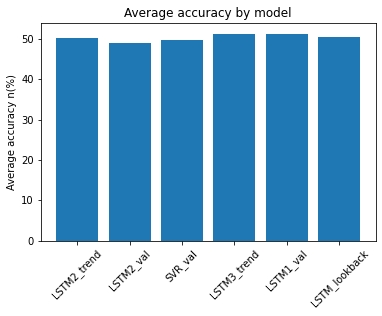

In [ ]:
plt.bar(average_acc.Model,average_acc['Average accuracy']*100)
plt.ylabel('Average accuracy n(%)')
#plt.xlabel('Model')
plt.title('Average accuracy by model')

# Change rotation of x-axis tick labels
plt.xticks(rotation=45)

# Show the chart
plt.show()

<BarContainer object of 6 artists>

Text(0, 0.5, 'Total profit')

Text(0.5, 1.0, 'Total profit by model')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'LSTM2_trend'),
  Text(1, 0, 'LSTM2_val'),
  Text(2, 0, 'SVR_val'),
  Text(3, 0, 'LSTM3_trend'),
  Text(4, 0, 'LSTM1_val'),
  Text(5, 0, 'LSTM_lookback')])

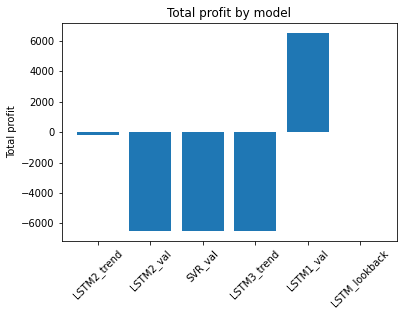

In [ ]:
plt.bar(total_profit.Model,total_profit['Total profit'])
plt.ylabel('Total profit')
#plt.xlabel('Model')
plt.title('Total profit by model')

# Change rotation of x-axis tick labels
plt.xticks(rotation=45)

# Show the chart
plt.show()